In [73]:
!pip install numpy pandas matplotlib seaborn iminuit


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit

In [75]:
detA = pd.read_csv("../data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("../data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("../data/DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])

Text(0, 0.5, 'Frequency')

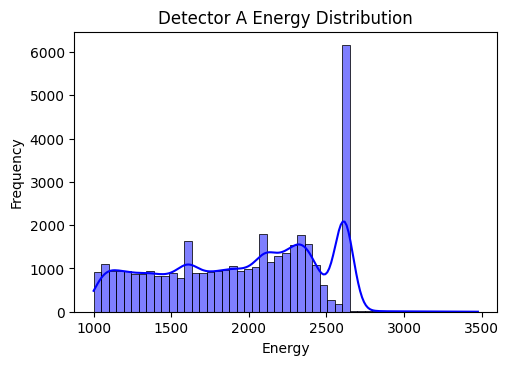

In [76]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(detA['energy'], kde=True, color='blue')
plt.title('Detector A Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')

Text(0, 0.5, 'Class Score')

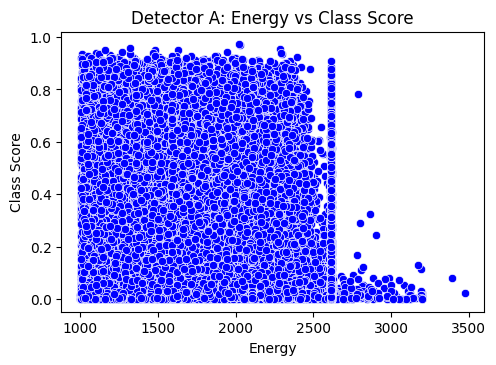

In [77]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x='energy', y='class_score', data=detA, color='blue')
plt.title('Detector A: Energy vs Class Score')
plt.xlabel('Energy')
plt.ylabel('Class Score')

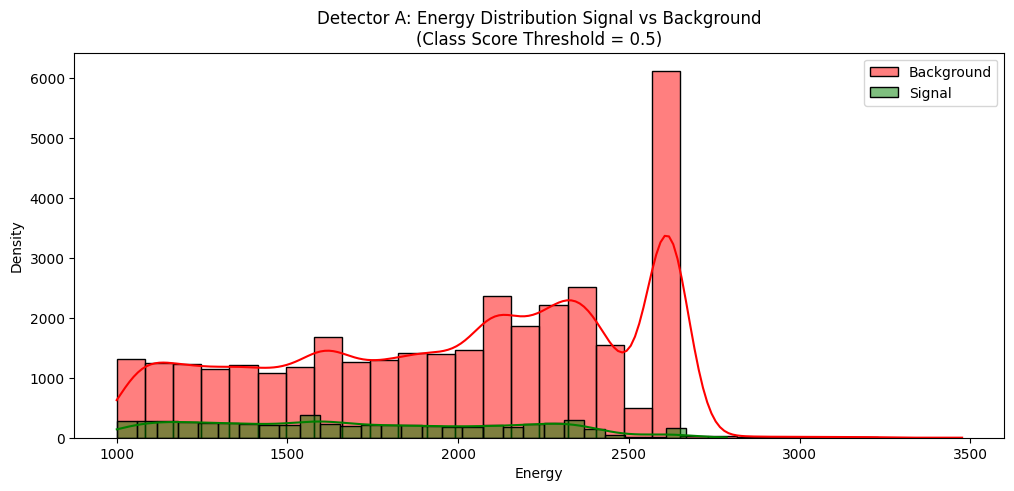

In [78]:
def split_plot(data, name, thresh=0.5, bins=30):
    detSignal = data[data['class_score'] > thresh]
    detBackground = data[data['class_score'] <= thresh]
    plt.figure(figsize=(12, 5))
    sns.histplot(detBackground['energy'], color='red', label='Background', kde=True, bins=bins)
    sns.histplot(detSignal['energy'], color='green', label='Signal', kde=True, bins=bins)
    plt.title(f'{name}: Energy Distribution Signal vs Background\n(Class Score Threshold = {thresh})')
    plt.xlabel('Energy')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

split_plot(detA, 'Detector A', 0.5)

# 2a. Use 1592 keV peak in Detector A to set a cutting threshold


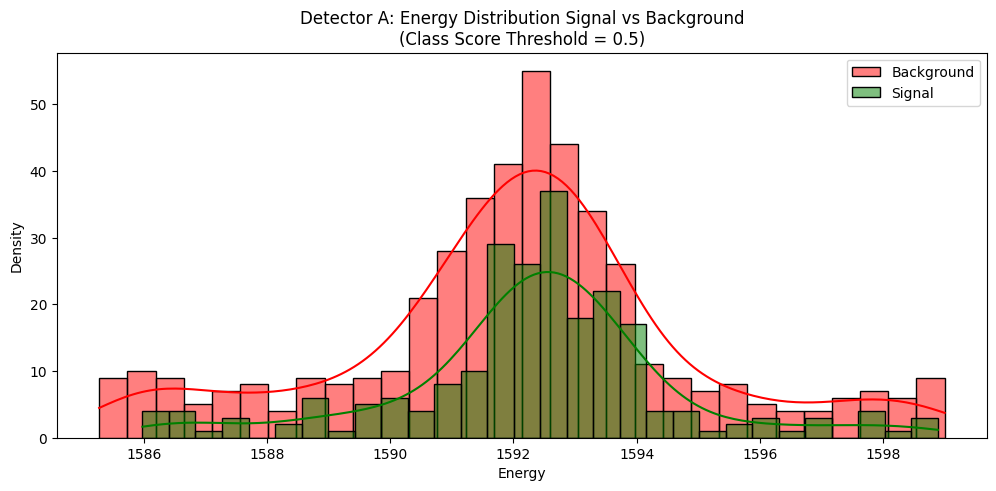

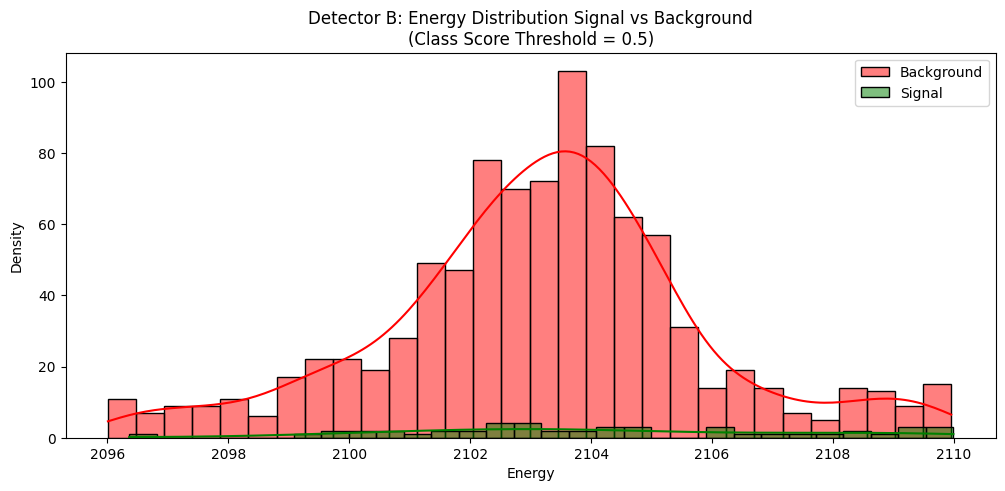

In [79]:
delta = 7
cA, cB, cC = [1592, 2103, 2039]
detA_select = (cA-delta, cA+delta, cA)
detB_select = (cB-delta, cB+delta, cB)
detC_select = (cC-delta, cC+delta, cC)

aReg = detA[(detA['energy'] > detA_select[0]) & (detA['energy'] < detA_select[1])]
bReg = detB[(detB['energy'] > detB_select[0]) & (detB['energy'] < detB_select[1])]

split_plot(aReg, 'Detector A', 0.5)
split_plot(bReg, 'Detector B', 0.5)

Best Threshold: 0.0900, TPR: 0.7847, FPR: 0.2704


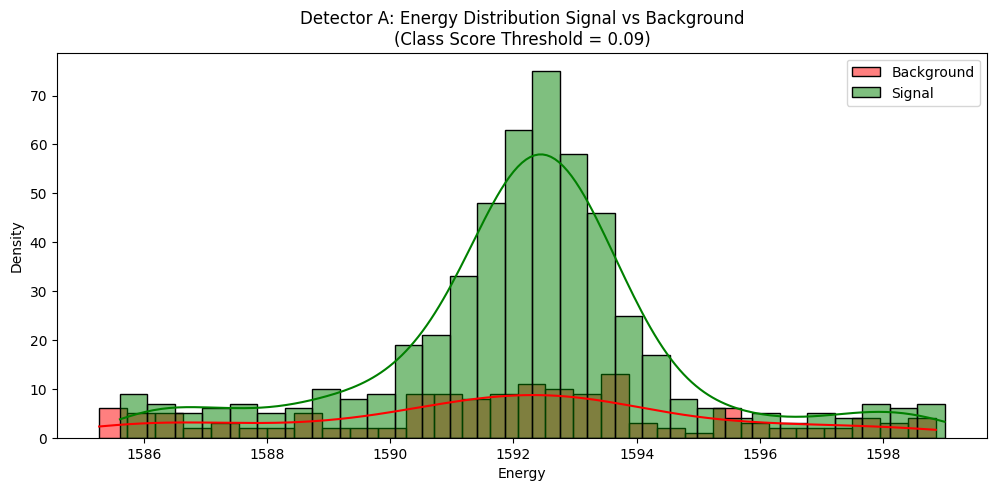

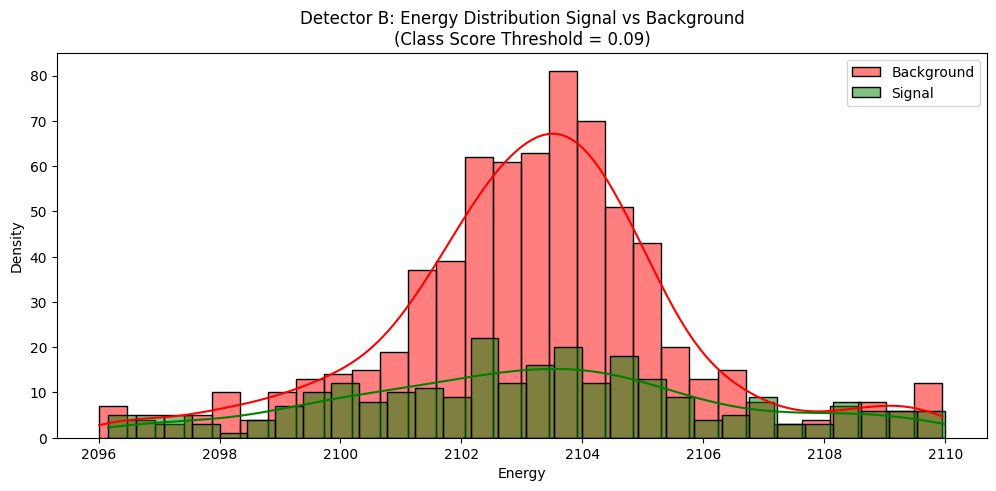

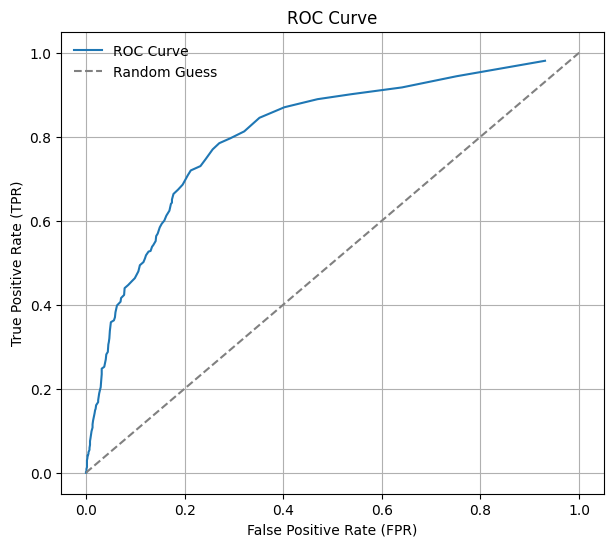

In [80]:
fpr = []
tpr = []
best_TPR = 0
best_FPR = 1
threshold = 0

while threshold <= 1:
    # sigA is mostly true positives
    # sigB is mostly true negatives
    sigA = aReg[aReg['class_score'] > threshold]
    bkgA = aReg[aReg['class_score'] <= threshold]
    sigB = bReg[bReg['class_score'] > threshold]
    bkgB = bReg[bReg['class_score'] <= threshold]
    #Calc TPR, FPR and collect for ROC curve
    TPR = len(sigA) / (len(sigA) + len(bkgA))
    FPR = len(sigB) / (len(sigB) + len(bkgB))
    fpr.append(FPR)
    tpr.append(TPR)
    #Capture best values
    if TPR - FPR > best_TPR - best_FPR:
        best_TPR = TPR
        best_FPR = FPR
        best_threshold = threshold
    threshold += 0.01

print(f"Best Threshold: {best_threshold:.4f}, TPR: {best_TPR:.4f}, FPR: {best_FPR:.4f}")
split_plot(aReg, 'Detector A', best_threshold)
split_plot(bReg, 'Detector B', best_threshold)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linestyle='-', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(frameon=False)
plt.grid()
plt.show()
    



# 4a Supply cuts to ABC

# 4b. Subtract baseline using linear + Gaussian model

In [81]:
def fit_signal_background(data, expected_center, E_min, E_max, n_bins=30):
    reg_select = data[(data['energy'] > E_min) & (data['energy'] < E_max)]
    intervals, bins = pd.cut(reg_select['energy'], bins=n_bins, retbins=True)
    x_data = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]
    y_data = intervals.value_counts().sort_index().values

    def fit_func(x_data, A, mu, sigma, a, b):
        bkg = a * x_data + b
        gauss_model = A * np.exp(-0.5 * ((x_data - mu) / sigma) ** 2)
        return bkg + gauss_model

    def chi2(A, mu, sigma, a, b):
        y_model = fit_func(x_data, A, mu, sigma, a, b)
        quad_diffs = (y_data - y_model) ** 2
        return np.sum(quad_diffs / y_data)
    
    m = Minuit(chi2, A=np.max(y_data)/2, mu=expected_center, sigma=2, a=0, b=0)
    m.limits['sigma'] = (0, None)
    m.migrad()
    A_fit, mu_fit, sigma_fit, a_fit, b_fit = m.values['A','mu','sigma','a','b']
    print('A_fit:', A_fit, 'mu_fit:', mu_fit, 'sigma_fit:', sigma_fit)
    print('a_fit:', a_fit, 'b_fit:', b_fit)
    bkgfit_y = a_fit * x_data + b_fit
    modelfit_y = A_fit * np.exp(-0.5 * ((x_data - mu_fit) / sigma_fit) ** 2)
    total_model_y = bkgfit_y + modelfit_y

    # Plot signal, backgound, and measured
    plt.plot(x_data, total_model_y, label = 'Total model')
    plt.plot(x_data, modelfit_y,'-.', label = 'Signal Model')
    plt.plot(x_data, bkgfit_y, label = 'Background Model')
    plt.scatter(x_data, y_data, color='black', label = 'Measured Histogram')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Counts per bin')
    plt.title('Modelling')
    plt.legend()
    plt.show()
    
    return x_data, bin_width, y_data - bkgfit_y



A_fit: 86.12215124956998 mu_fit: 1592.3946814921069 sigma_fit: 0.9976767324875189
a_fit: 0.06107019618477608 b_fit: -87.9120911732626


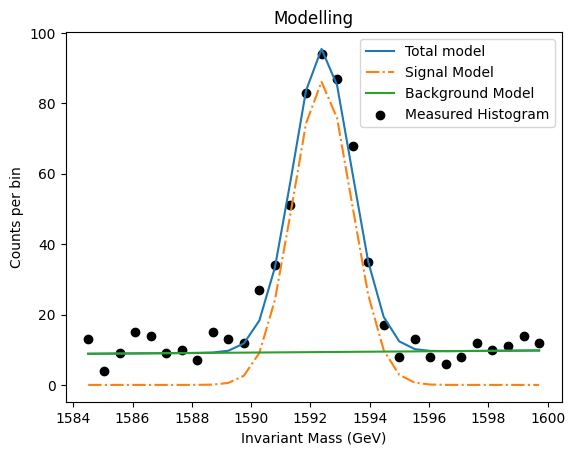

In [ ]:
# Testing on Detector A without cut
bin_centersA, bin_widthA, rmvd_bkgA = fit_signal_background(detA, 1592, 1584, 1600, n_bins=30)

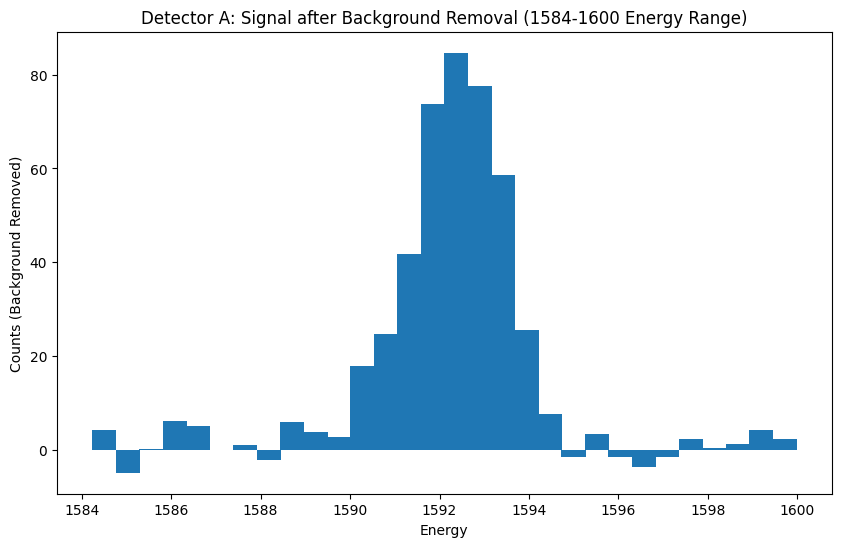

In [ ]:
# Testing on Detector A without cut
plt.figure(figsize=(10,6))
plt.bar(bin_centersA, rmvd_bkgA, width=bin_widthA)
plt.xlabel('Energy')
plt.ylabel('Counts (Background Removed)')
plt.title('Detector A: Signal after Background Removal (1584-1600 Energy Range)')
plt.show()

Processing Detector A
Expected Center: 1592, Energy Range: 1585-1599
A_fit: 73.01597089910705 mu_fit: 1592.3816105451674 sigma_fit: 1.021051847176081
a_fit: -0.16576017270537954 b_fit: 272.29240730362335


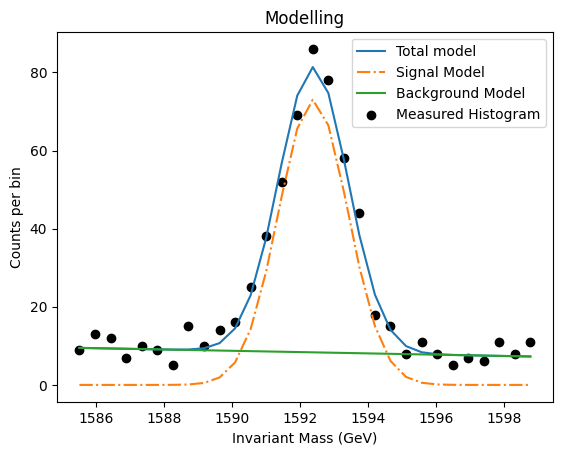

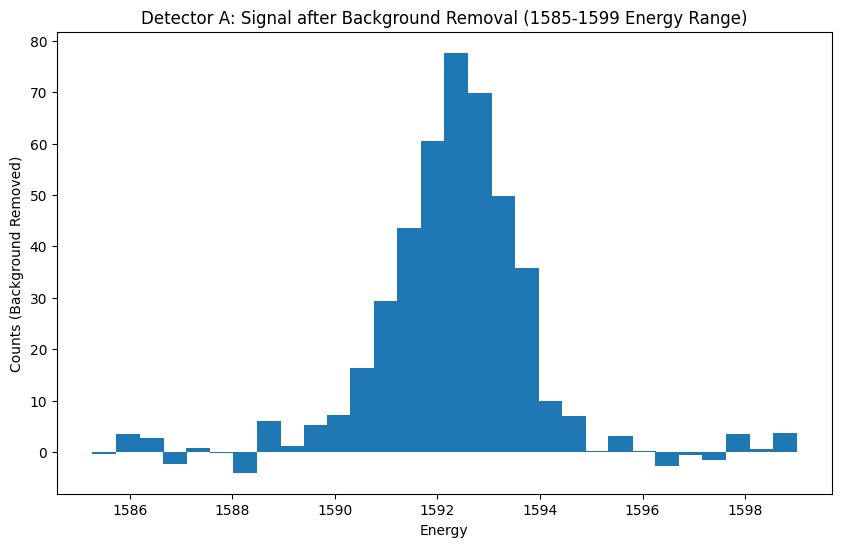

Processing Detector B
Expected Center: 2103, Energy Range: 2096-2110
A_fit: 78.70811685788635 mu_fit: 2103.2655993798726 sigma_fit: 1.480229999616299
a_fit: 0.08659088323831358 b_fit: -172.00434429518467


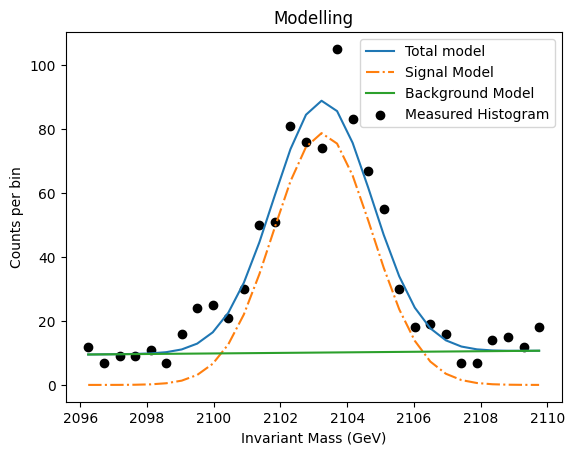

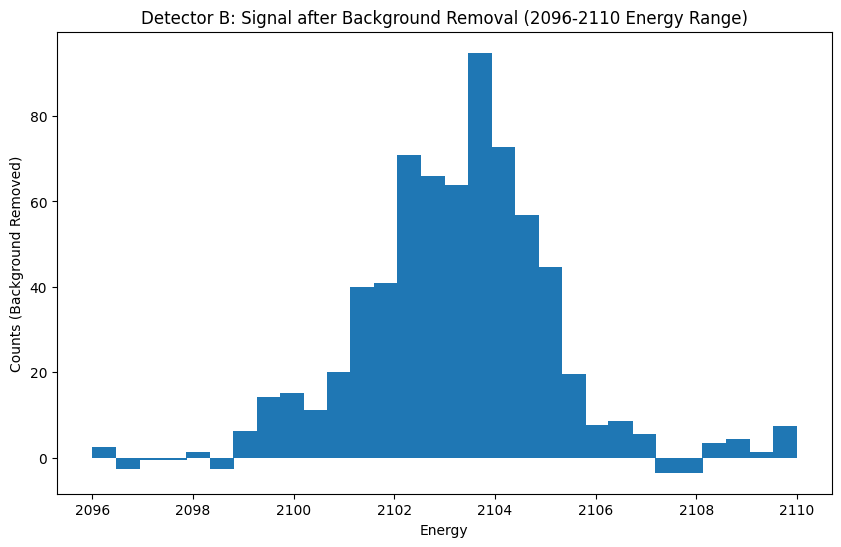

Processing Detector C
Expected Center: 2039, Energy Range: 2032-2046
A_fit: 3.809533299721925 mu_fit: 2038.3882950062832 sigma_fit: 0.9249576988272932
a_fit: 0.08981080578554083 b_fit: -174.58887219522774


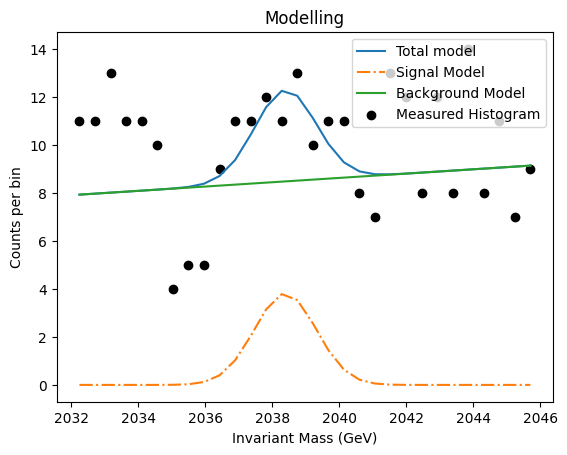

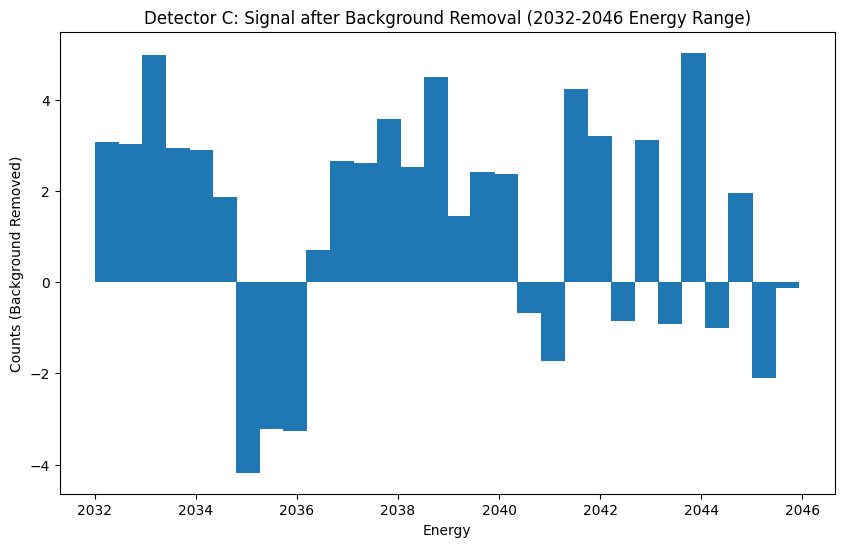

In [ ]:
for (label, det, limits) in [('A', detAcut, detA_select), ('B', detBcut, detB_select), ('C', detCcut, detC_select)]:
    print(f"Processing Detector {label}")
    print(f"Expected Center: {limits[2]}, Energy Range: {limits[0]}-{limits[1]}")
    bin_centers, bin_width, rmvd_bkg = fit_signal_background(det, limits[2], limits[0], limits[1], n_bins=30)
    plt.figure(figsize=(10,6))
    plt.bar(bin_centers, rmvd_bkg, width=bin_width)
    plt.xlabel('Energy')
    plt.ylabel('Counts (Background Removed)')
    plt.title(f'Detector {label}: Signal after Background Removal ({limits[0]}-{limits[1]} Energy Range)')
    plt.show()

# Scan for Signal Ranges around proposed energy level of C
This is introducing selection Bias... should not use?

Processing Detector C, with delta=4
Expected Center: 2039, Energy Range: 2035-2043
A_fit: 132.92039618340635 mu_fit: 2039.466151764133 sigma_fit: 18.794617212189774
a_fit: -0.03054593271326505 b_fit: -64.68926286004019


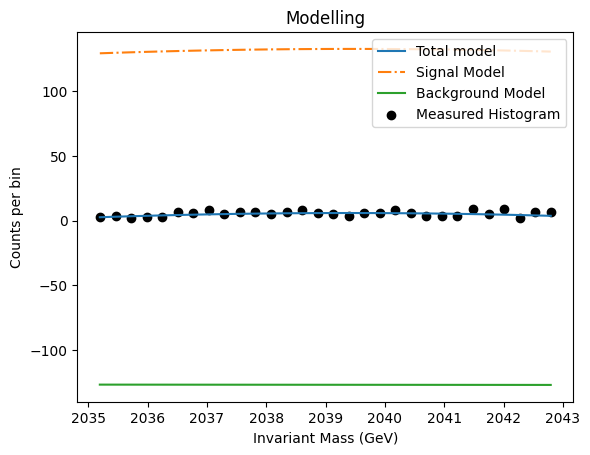

Processing Detector C, with delta=5
Expected Center: 2039, Energy Range: 2034-2044
A_fit: 12.71406937272358 mu_fit: 2047.4748098275716 sigma_fit: 16.687377249473695
a_fit: -0.0011878833441817222 b_fit: -2.5652709795185538


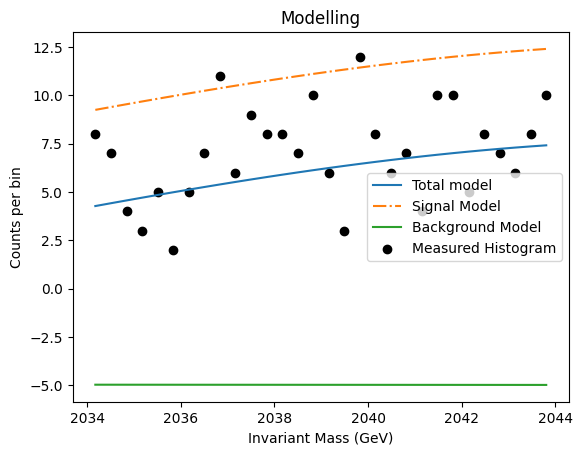

Processing Detector C, with delta=6
Expected Center: 2039, Energy Range: 2033-2045
A_fit: 2.389373751012355 mu_fit: 2041.4804677066754 sigma_fit: 2.997141944664471
a_fit: 0.0015844934069605605 b_fit: 3.2528643696061237


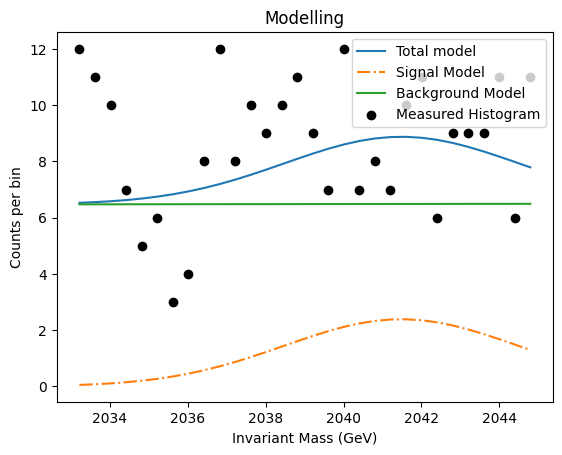

Processing Detector C, with delta=7
Expected Center: 2039, Energy Range: 2032-2046
A_fit: 3.809533299721925 mu_fit: 2038.3882950062832 sigma_fit: 0.9249576988272932
a_fit: 0.08981080578554083 b_fit: -174.58887219522774


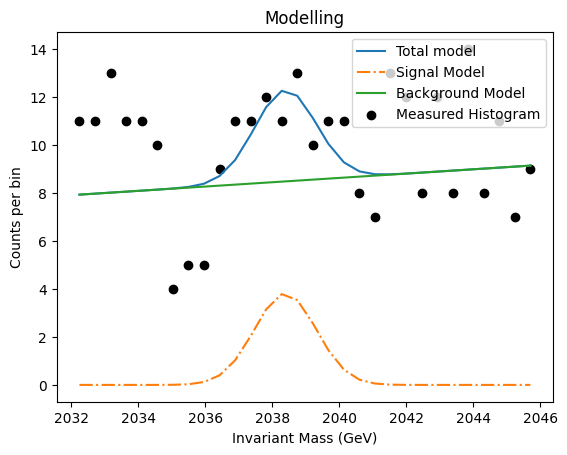

Processing Detector C, with delta=8
Expected Center: 2039, Energy Range: 2031-2047
A_fit: 2.3836821833772674 mu_fit: 2042.1214620498426 sigma_fit: 2.9490708410697013
a_fit: 0.0022292692492620345 b_fit: 4.726156186784316


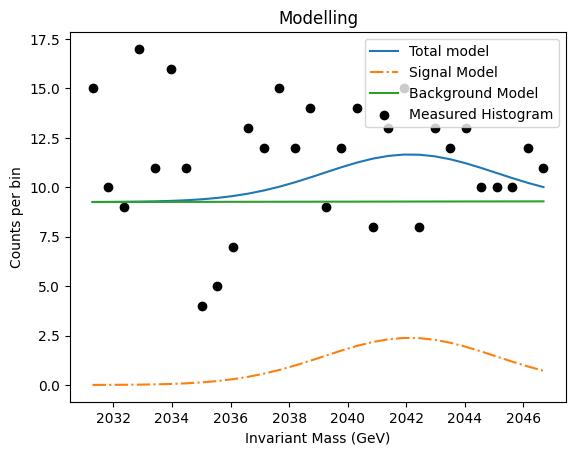

Processing Detector C, with delta=9
Expected Center: 2039, Energy Range: 2030-2048
A_fit: 7860.66380254546 mu_fit: 2251.029918997268 sigma_fit: 62.57646292061293
a_fit: -1.236192915549628 b_fit: 2506.32522043724


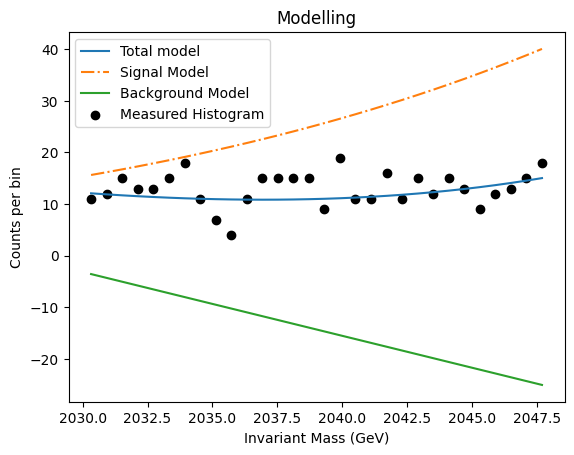

In [86]:
label = 'C'
det = detC
for delta in range(4, 10, 1):
    limits = (cC-delta, cC+delta, cC)
    print(f"Processing Detector {label}, with delta={delta}")
    print(f"Expected Center: {limits[2]}, Energy Range: {limits[0]}-{limits[1]}")
    bin_centers, bin_width, rmvd_bkg = fit_signal_background(det, limits[2], limits[0], limits[1], n_bins=30)
